# jms: some code for basic NN fitting of telescope temp+auxillary data
## Updated 3/31/24: ran on cleaned telemetry data

In [2]:
! pip install --upgrade numpy==1.22
! pip install --upgrade scipy==1.9
! pip install -q flax>=0.7.5

/global/common/software/desi/perlmutter/desiconda/20230111-2.1.0/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-1.22.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
^C
ERROR: Operation cancelled by user
Defaulting to user installation because normal site-packages is not writeable
  Using cached scipy-1.9.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (43.9 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.86 requires numpy>=1.24.1, but you have numpy 1.22.4 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
specprod-db 1.1.0 requires numpy<1.23, but you have numpy 1.26.4 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.26.4 which is incompatible.


In [1]:
from typing import Sequence
import jax.numpy as jnp
import numpy as np
import jax
import optax
import flax.linen as nn
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false' #otherwise OOM sometimes on gpu

Open the cleaned telemetry data

In [2]:
# load cleaned data
fpath = '../cleaned_dataset_10mins/outputs/shifted_table.fits'
from astropy.table import Table
dat = Table.read(fpath, format='fits')
cleaned = dat.to_pandas()
cleaned.dropna(axis=0,inplace=True)

In [3]:
# copy the air_temp column shifted forward one obsday in a new column called 'air_temp_nextday'
shifted_full = cleaned.copy()
shifted_full['air_temp_nextday'] = cleaned['air_temp'].shift(-1)
# Remove the first and last rows
shifted_full = shifted_full.iloc[1:-1].dropna()
shifted_full

,mirror_cooling,temperature,pressure,humidity,wind_speed,wind_direction,mirror_temp,air_temp,mirror_cooling_var,temperature_var,pressure_var,humidity_var,wind_speed_var,wind_direction_var,mirror_temp_var,air_temp_var,obsday,adjusted_desired_temp,air_temp_nextday
1,0.601317,21.453405,793.496934,33.679609,9.568663,169.116535,20.381133,21.935603,0.238845,2.896639,0.404218,33.033023,27.494060,4876.835674,0.276811,4.534386,b'2021-09-16',18.0,20.452457
2,0.670060,19.348314,796.483708,53.821591,5.919081,136.602343,18.581965,20.452457,0.214482,0.617031,0.477390,43.390580,5.111971,6407.702694,0.468626,1.965519,b'2021-09-17',18.0,19.840065
3,0.607054,18.124226,795.954992,77.304527,9.489310,174.769908,18.539266,19.840065,0.238509,1.130825,1.230947,87.270898,39.647019,5437.799939,0.347746,1.877360,b'2021-09-18',18.0,19.801253
4,0.820000,18.435370,793.885757,56.468469,14.201635,169.605956,18.239396,19.801253,0.144727,1.745180,0.849827,473.589945,49.491711,2375.040069,0.114214,2.293055,b'2021-09-19',18.0,19.573302
5,1.000000,18.440468,796.016577,41.931388,11.936491,224.588630,17.995493,19.573302,0.000000,1.162407,1.556882,23.431062,21.559366,2688.718538,0.002478,0.694363,b'2021-09-20',18.0,20.367720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,1.000000,-2.022445,795.000000,34.049291,19.899718,131.787030,-0.009532,0.263017,0.000000,9.148258,0.000000,245.372451,106.247777,3414.162997,0.016121,2.378200,b'2023-02-16',-3.0,4.533253
410,1.000000,4.533968,795.000000,23.233633,29.736987,107.191097,0.763877,4.533253,0.000000,2.514957,0.000000,32.061395,180.518908,167.256263,0.364793,1.523822,b'2023-02-17',4.0,7.790498
411,0.932275,6.787604,795.000000,53.587232,15.043157,132.737188,4.543186,7.790498,0.062277,2.864519,0.000000,56.212117,78.637620,756.692312,3.008891,2.613771,b'2023-02-18',4.0,7.350313
412,1.000000,5.772312,794.222696,69.271628,23.225928,131.953170,6.631846,7.350313,0.000000,0.901035,1.342800,391.264808,65.742586,201.828787,0.094299,0.262968,b'2023-02-19',4.0,7.895247


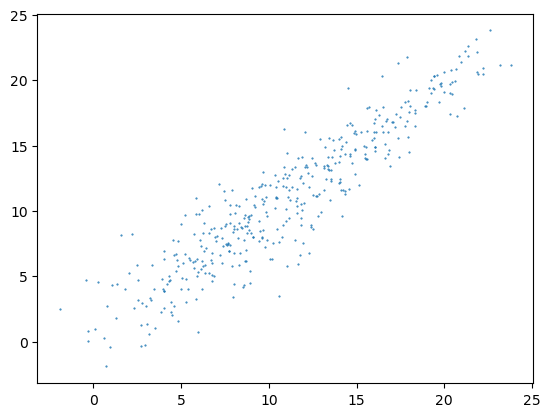

In [4]:
plt.plot(shifted_full['air_temp'], shifted_full['air_temp_nextday'], '.',ms=1)

Will need to deal with the fact that e.g. the tower and telescope/dome data are not taken at the same time -> do some kind of interpolation (after cleaning NaNs)

### Flax NN boilerplate with appropriate dimensionality to predict Y from X


In [5]:
#Training functions

# This is a training function that doesn't use biases in the last layer
class MLP(nn.Module):
  features: Sequence[int]
  @nn.compact
  def __call__(self, x):
    for feat in self.features[:-1]:
      x = nn.tanh(nn.Dense(feat)(x))
    x = nn.Dense(self.features[-1],use_bias=False)(x)
    return x

# This is a trianing function that does use biases in the last layer
class MLP_LL(nn.Module):
  features: Sequence[int]
  @nn.compact
  def __call__(self, x):
    for feat in self.features[:-1]:
      x = nn.tanh(nn.Dense(feat)(x))
    x = nn.tanh(nn.Dense(self.features[-1],use_bias=True)(x))
    return x

# Returns the mean squared difference between predictions and actual values 
def loss_out(params, batch,model):
    features, target = batch
    preds = model.apply(params, features)
    return optax.l2_loss(preds, target).mean()

def normalize(data,scales):
    x_data,y_data = data
    return (x_data-scales['x_mean'])/scales['x_std'],(y_data-scales['y_mean'])/scales['y_std']
def unnormalize_y(data,scales):
    _,y_data = data
    return y_data*scales['y_std']+scales['y_mean']

def run_sgd(dataset,model,pars,batch_size,nn_seed=0,
            num_epochs=10_000,learning_rate = 1e-3,beta1=0.9,beta2=0.999,
            adam=True,do_batch=False,scales={},norm=False):
    # start where we ended up before
    x_data,y_data = dataset
    n_batch = y_data.shape[0]
    params = jax.jit(model.init)(jax.random.PRNGKey(nn_seed), x_data[0]) if pars is None else pars
    x_mean,y_mean = x_data.mean(axis=0),y_data.mean(axis=0)
    x_std,y_std = x_data.std(axis=0),y_data.std(axis=0)
    scales['x_mean'] = x_mean
    scales['x_std'] = x_std
    scales['y_mean'] = y_mean
    scales['y_std'] = y_std
    dataset_train = normalize(dataset,scales) if norm else dataset
    tx = optax.adam(learning_rate,beta1,beta2) if adam else optax.sgd(learning_rate,beta1)
    opt_state = tx.init(params)

    @jax.jit
    def loss(params, batch):
        # print('batch', batch)
        features, target = batch
        preds = model.apply(params, features)
        return optax.l2_loss(preds, target).mean()

    @jax.jit
    def train_step(params, opt_state, batch):
        grads = jax.grad(loss)(params, batch)
        updates, opt_state = tx.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        return params, opt_state

    # restructure the data into batches
    if(do_batch):
        X_train, Y_train = dataset_train
        ds_train = [(X_train[i*batch_size:(i+1)*batch_size,:], 
                    Y_train[i*batch_size:(i+1)*batch_size,:]) for i in range(n_batch)]
        ds_train.append((X_train[n_batch*batch_size:,:],
                        Y_train[n_batch*batch_size:,:]))
    else:
        ds_train = dataset_train
    def train(params, opt_state, ds_train,num_epochs,do_batch=False):
        losses,epoch_params = [],[]
        for epoch in tqdm(range(num_epochs)):
            if(do_batch):
                for i,batch in enumerate(ds_train):
                    params, opt_state = train_step(params, opt_state, batch)
            else:
                params, opt_state = train_step(params, opt_state, ds_train)
            losses.append(loss(params, dataset_train)) # we can do this since we have a small dataset
            epoch_params.append(params)
        return params, opt_state,losses,epoch_params
    trained_params, trained_opt_state,losses,epoch_params = train(params, opt_state, ds_train,num_epochs=num_epochs)
    # Summary
    best_idx = np.argmin(losses)
    best_params = epoch_params[best_idx]
    logp = losses[best_idx] #save the best, even though only saving every epoch
    return model,best_params,logp,losses,scales

def train_flax(dataset,pars=None,m=16,n_batch=40):
    #train network
    d_out = dataset[1].shape[1]
    model = MLP([m,m,d_out]) 
    nn_surro, nn_w,logp,losses,scales_test = run_sgd(dataset, model,pars,batch_size=1,
                                                     num_epochs=1_000,learning_rate = 1e-2,beta1=0.9,beta2=0.999,
                                                    adam=True,do_batch=False,norm=False,nn_seed=0)
    return nn_surro, nn_w,logp,losses,scales_test
        

In [6]:
# Let's add a 50/50 train/test split
import random
def split_rows_randomly(x, random_seed=42):
    # Set random seed if provided
    if random_seed is not None:
        random.seed(random_seed)
    
    # Create a list of row indices
    rows = list(range(x))
    
    # Shuffle the row indices
    random.shuffle(rows)
    
    # Calculate the number of rows for each array
    half_rows = x // 2
    
    # Split the shuffled row indices into two arrays
    array1 = rows[:half_rows]
    array2 = rows[half_rows:]
    
    return array1, array2

train_idx = split_rows_randomly(shifted_full.shape[0], random_seed=42)[0]
test_idx = split_rows_randomly(shifted_full.shape[0], random_seed=42)[1]

In [7]:
thinning_factor = 1 #just for demonstration purposes, #TODO data loader
train_data_1d = {"x":jnp.array(shifted_full.iloc[train_idx]['adjusted_desired_temp'])[:,None],"y":jnp.array(shifted_full.iloc[train_idx]['air_temp_nextday'])} #extra "None" for 1d data
test_data_1d = {"x":jnp.array(shifted_full.iloc[test_idx]['adjusted_desired_temp'])[:,None],"y":jnp.array(shifted_full.iloc[test_idx]['air_temp_nextday'])} #diff stride for thin factor

nn_surro_1d, nn_weight_1d,best_loss_1d,losses_1d,_ = train_flax((train_data_1d['x'],train_data_1d['y'][:,None]),pars=None)


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


  0%|          | 0/1000 [00:00<?, ?it/s]

### Look at the loss

Text(0, 0.5, 'log loss')

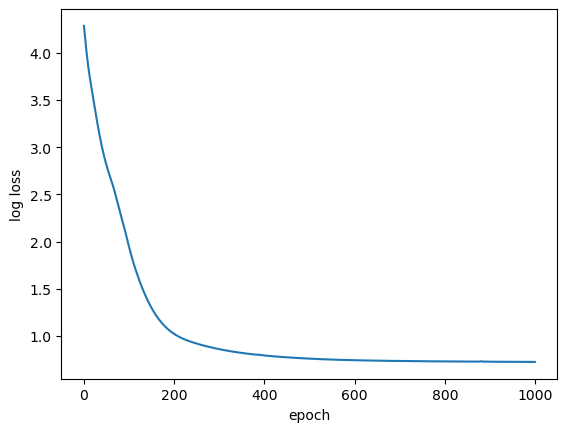

In [8]:
#plt.figure(figsize=(2,2))
plt.plot(np.log(losses_1d))
plt.xlabel('epoch')
plt.ylabel('log loss')

## Train and look at some train/test error
FIXME it looks like this is not once per night so there are repeat input temps for diff times at the same night

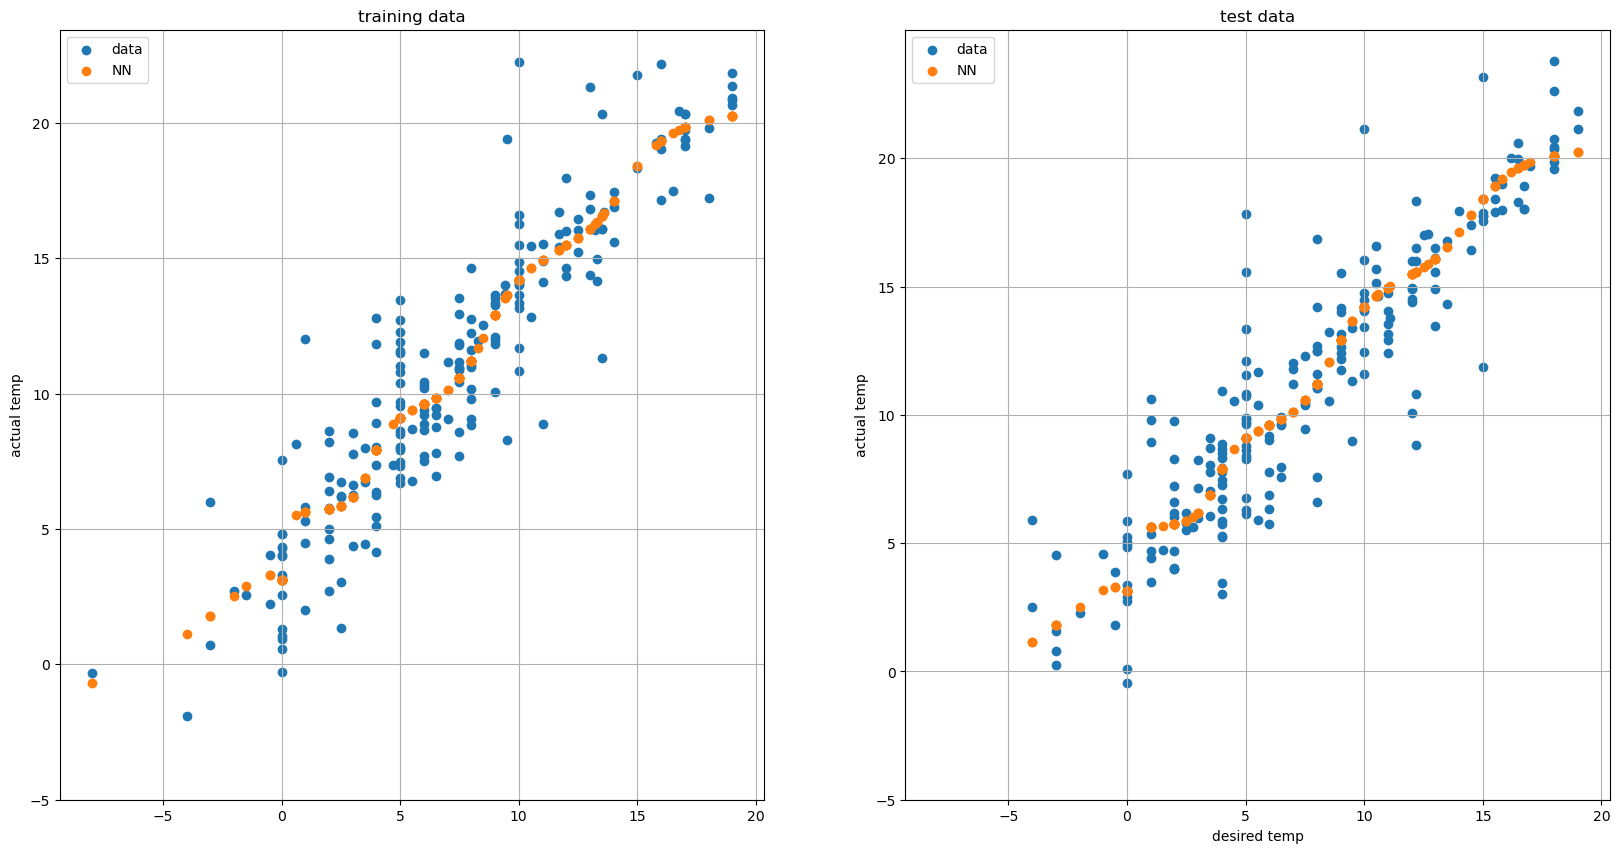

In [9]:
fig,ax = plt.subplots(1,2,figsize=(20, 10),sharex=True)
ax[0].set_title("training data")
ax[0].scatter(train_data_1d['x'].T[0,:],train_data_1d['y'],label='data')
ax[0].scatter(train_data_1d['x'].T[0,:],nn_surro_1d.apply(nn_weight_1d,train_data_1d['x']),label='NN')
ax[1].set_title("test data")
ax[1].scatter(test_data_1d['x'].T[0,:],test_data_1d['y'],label='data')
ax[1].scatter(test_data_1d['x'].T[0,:],nn_surro_1d.apply(nn_weight_1d,test_data_1d['x']),label='NN')
ax[1].set_xlabel('desired temp')
ax[0].set_ylabel('actual temp')
ax[1].set_ylabel('actual temp')
ax[0].grid(True)
ax[1].grid(True)

for a in ax:
    a.set_xticks(range(-5, 25, 5))  # Adjust range and step as needed
    a.set_yticks(range(-5, 25, 5))
    a.legend()

median absolute deviation: 1.0989828


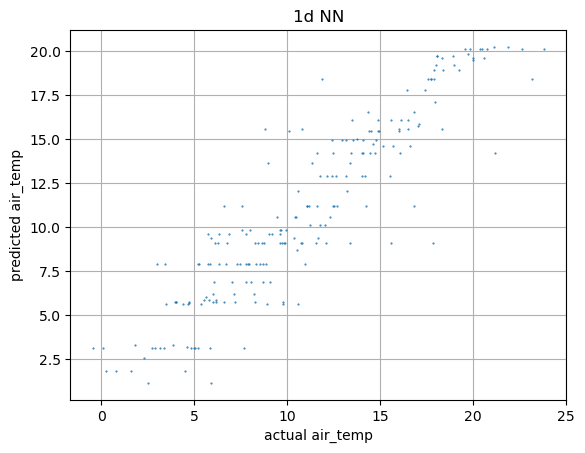

In [10]:
pred_1d = nn_surro_1d.apply(nn_weight_1d,test_data_1d['x'])[:,0]
actu_1d = shifted_full.iloc[test_idx]['air_temp_nextday']
plt.plot(shifted_full.iloc[test_idx]['air_temp_nextday'],nn_surro_1d.apply(nn_weight_1d,test_data_1d['x'])[:,0], '.', ms=1, label='NN')
plt.grid()
plt.xlabel('actual air_temp')
plt.ylabel('predicted air_temp')
plt.title('1d NN')
print('median absolute deviation:', np.median(np.abs((pred_1d - actu_1d))))

## 3D input example

In [11]:
train_data_3d = {"x":jnp.vstack([jnp.array(shifted_full.iloc[train_idx]['adjusted_desired_temp']),
                                jnp.array(shifted_full.iloc[train_idx]['air_temp']),
                                jnp.array(shifted_full.iloc[train_idx]['temperature'])]).T,
                "y":jnp.array(shifted_full.iloc[train_idx]['air_temp_nextday'])}
test_data_3d = {"x":jnp.vstack([jnp.array(shifted_full.iloc[test_idx]['adjusted_desired_temp']),
                                jnp.array(shifted_full.iloc[test_idx]['air_temp']),
                                jnp.array(shifted_full.iloc[test_idx]['temperature'])]).T,
                "y":jnp.array(shifted_full.iloc[test_idx]['air_temp_nextday'])}


In [12]:
nn_surro_3d, nn_weight_3d,best_loss_3d,losses_3d,_ = train_flax((train_data_3d['x'],train_data_3d['y'][:,None]),pars=None)


  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0, 0.5, 'log loss')

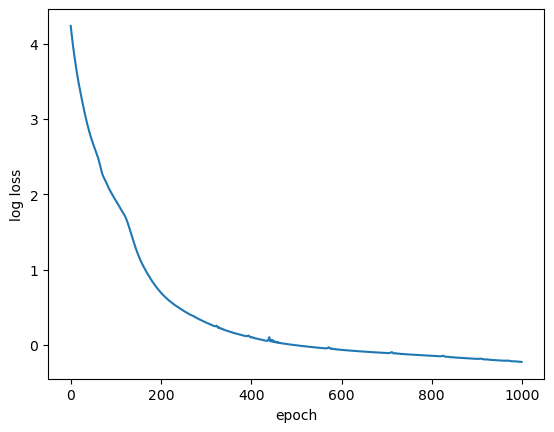

In [13]:
#plt.figure(figsize=(2,2))
plt.plot(np.log(losses_3d))
plt.xlabel('epoch')
plt.ylabel('log loss')

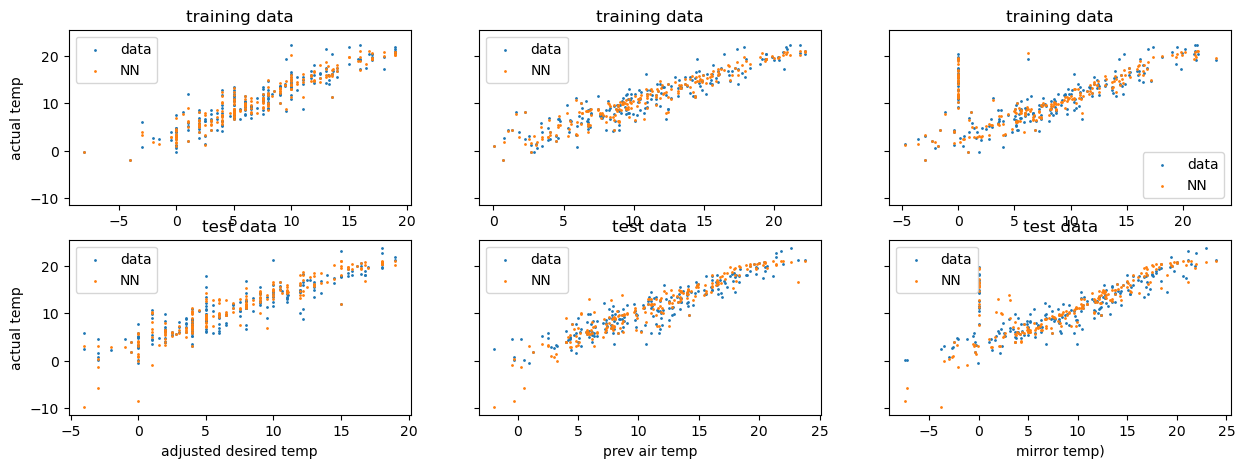

In [14]:
fig,ax = plt.subplots(2,3,figsize=(15,5),sharey=True)
for i in range(3): 
    ax[0,i].set_title("training data")
    ax[0,i].scatter(train_data_3d['x'][:,i],train_data_3d['y'],label='data', s=1)
    ax[0,i].scatter(train_data_3d['x'][:,i],nn_surro_3d.apply(nn_weight_3d,train_data_3d['x'])[:,0],label='NN', s=1)
    
    ax[1,i].scatter(test_data_3d['x'][:,i],test_data_3d['y'],label='data', s=1)
    ax[1,i].scatter(test_data_3d['x'][:,i],nn_surro_3d.apply(nn_weight_3d,test_data_3d['x'])[:,0],label='NN', s=1)
    ax[1,i].set_title("test data")
    
ax[1,0].set_xlabel('adjusted desired temp')
ax[1,1].set_xlabel('prev air temp')
ax[1,2].set_xlabel('mirror temp)')
ax[0,0].set_ylabel('actual temp')
ax[1,0].set_ylabel('actual temp')

for i in range(2):
    for j in range(3):
        # Add legend to each subplot
        ax[i, j].legend()

median absolute deviation: 1.2351713


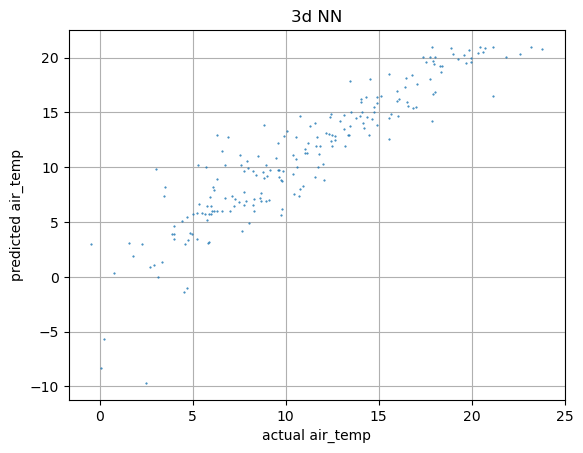

In [15]:
pred_3d = nn_surro_3d.apply(nn_weight_3d,test_data_3d['x'])[:,0]
actu_3d = shifted_full.iloc[test_idx]['air_temp_nextday']

plt.plot(shifted_full.iloc[test_idx]['air_temp_nextday'],nn_surro_3d.apply(nn_weight_3d,test_data_3d['x'])[:,0], '.', ms=1, label='NN')
plt.grid()
plt.xlabel('actual air_temp')
plt.ylabel('predicted air_temp')
plt.title('3d NN')
print('median absolute deviation:', np.median(np.abs((pred_3d - actu_3d))))

# Training NN on Different Features

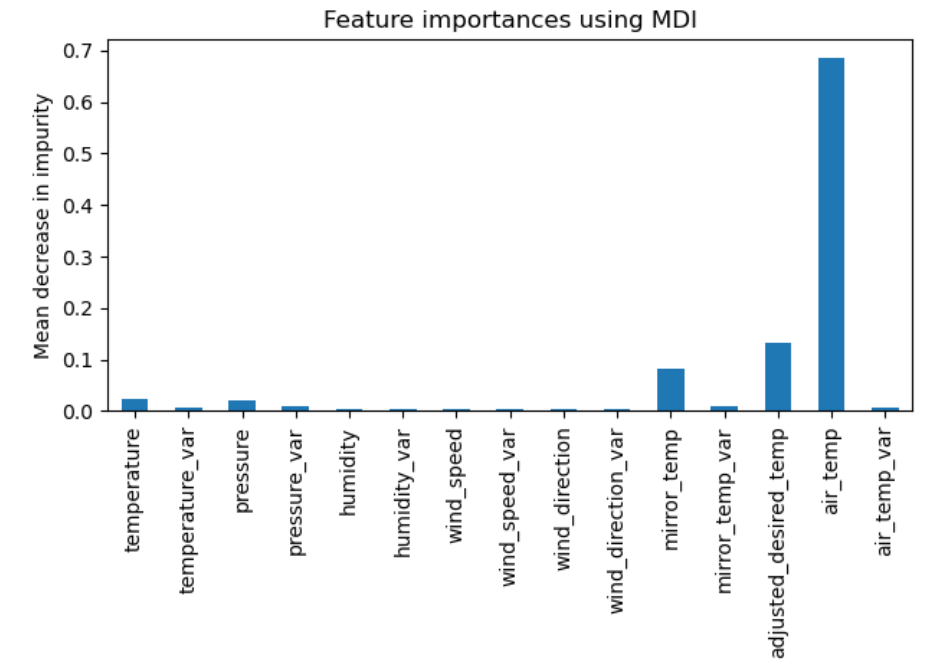

Features of interest are:
- air_temp
- adjusted_desired_temp
- mirror_temp
- mirror_temp_var
- temperature
- pressure

In [17]:
train_data_3d = {"x":jnp.vstack([jnp.array(shifted_full.iloc[train_idx]['air_temp']),
                                jnp.array(shifted_full.iloc[train_idx]['adjusted_desired_temp']),
                                jnp.array(shifted_full.iloc[train_idx]['temperature'])]).T,
                "y":jnp.array(shifted_full.iloc[train_idx]['air_temp_nextday'])}
test_data_3d = {"x":jnp.vstack([jnp.array(shifted_full.iloc[test_idx]['air_temp']),
                                jnp.array(shifted_full.iloc[test_idx]['adjusted_desired_temp']),
                                jnp.array(shifted_full.iloc[test_idx]['temperature'])]).T,
                "y":jnp.array(shifted_full.iloc[test_idx]['air_temp_nextday'])}
nn_surro_3d, nn_weight_3d,best_loss_3d,losses_3d,_ = train_flax((train_data_3d['x'],train_data_3d['y'][:,None]),pars=None)
mad = np.median(np.abs((nn_surro_3d.apply(nn_weight_3d,test_data_3d['x'])[:,0] - shifted_full.iloc[test_idx]['air_temp_nextday'])))
print(mad)


import itertools

features = ['air_temp', 'adjusted_desired_temp', 'mirror_temp', 'mirror_temp_var', 'temperature', 'pressure']
feature_combinations = itertools.combinations(features, 3)

# Note: train/test indices of the original are locked in with random seed

for combination in feature_combinations:
    train_data_3d = {"x":jnp.vstack([jnp.array(shifted_full.iloc[train_idx][combination[0]]),
                                jnp.array(shifted_full.iloc[train_idx][combination[1]]),
                                jnp.array(shifted_full.iloc[train_idx][combination[2]])]).T,
                "y":jnp.array(shifted_full.iloc[train_idx]['air_temp_nextday'])}
    test_data_3d = {"x":jnp.vstack([jnp.array(shifted_full.iloc[test_idx][combination[0]]),
                                jnp.array(shifted_full.iloc[test_idx][combination[1]]),
                                jnp.array(shifted_full.iloc[test_idx][combination[2]])]).T,
                "y":jnp.array(shifted_full.iloc[test_idx]['air_temp_nextday'])}
    nn_surro_3d, nn_weight_3d,best_loss_3d,losses_3d,_ = train_flax((train_data_3d['x'],train_data_3d['y'][:,None]),pars=None)
    
    # compute MAD
    print('MAD for ', combination)
    mad = np.median(np.abs((nn_surro_3d.apply(nn_weight_3d,test_data_3d['x'])[:,0] - shifted_full.iloc[test_idx]['air_temp_nextday'])))
    print(mad)
    

  0%|          | 0/1000 [00:00<?, ?it/s]

1.110681


  0%|          | 0/1000 [00:00<?, ?it/s]

MAD for  ('air_temp', 'adjusted_desired_temp', 'mirror_temp')
1.309083


  0%|          | 0/1000 [00:00<?, ?it/s]

MAD for  ('air_temp', 'adjusted_desired_temp', 'mirror_temp_var')
1.374279


  0%|          | 0/1000 [00:00<?, ?it/s]

MAD for  ('air_temp', 'adjusted_desired_temp', 'temperature')
1.110681


  0%|          | 0/1000 [00:00<?, ?it/s]

MAD for  ('air_temp', 'adjusted_desired_temp', 'pressure')
4.0375614


  0%|          | 0/1000 [00:00<?, ?it/s]

MAD for  ('air_temp', 'mirror_temp', 'mirror_temp_var')
1.4117537


  0%|          | 0/1000 [00:00<?, ?it/s]

MAD for  ('air_temp', 'mirror_temp', 'temperature')
1.2886286


  0%|          | 0/1000 [00:00<?, ?it/s]

MAD for  ('air_temp', 'mirror_temp', 'pressure')
4.037938


  0%|          | 0/1000 [00:00<?, ?it/s]

MAD for  ('air_temp', 'mirror_temp_var', 'temperature')
1.3807573


  0%|          | 0/1000 [00:00<?, ?it/s]

MAD for  ('air_temp', 'mirror_temp_var', 'pressure')
4.0375614


  0%|          | 0/1000 [00:00<?, ?it/s]

MAD for  ('air_temp', 'temperature', 'pressure')
4.037939


  0%|          | 0/1000 [00:00<?, ?it/s]

MAD for  ('adjusted_desired_temp', 'mirror_temp', 'mirror_temp_var')
1.2038069


  0%|          | 0/1000 [00:00<?, ?it/s]

MAD for  ('adjusted_desired_temp', 'mirror_temp', 'temperature')
1.2515225


  0%|          | 0/1000 [00:00<?, ?it/s]

MAD for  ('adjusted_desired_temp', 'mirror_temp', 'pressure')
4.037939


  0%|          | 0/1000 [00:00<?, ?it/s]

MAD for  ('adjusted_desired_temp', 'mirror_temp_var', 'temperature')
1.2512407


  0%|          | 0/1000 [00:00<?, ?it/s]

MAD for  ('adjusted_desired_temp', 'mirror_temp_var', 'pressure')
4.0375614


  0%|          | 0/1000 [00:00<?, ?it/s]

MAD for  ('adjusted_desired_temp', 'temperature', 'pressure')
4.037939


  0%|          | 0/1000 [00:00<?, ?it/s]

MAD for  ('mirror_temp', 'mirror_temp_var', 'temperature')
1.2906594


  0%|          | 0/1000 [00:00<?, ?it/s]

MAD for  ('mirror_temp', 'mirror_temp_var', 'pressure')
4.0375614


  0%|          | 0/1000 [00:00<?, ?it/s]

MAD for  ('mirror_temp', 'temperature', 'pressure')
4.037939


  0%|          | 0/1000 [00:00<?, ?it/s]

MAD for  ('mirror_temp_var', 'temperature', 'pressure')
4.0375614


# Test: Order of Features

In [20]:
from itertools import permutations

# Define the elements to permute
elements = ('air_temp', 'adjusted_desired_temp', 'temperature')

# Generate all permutations
all_permutations = permutations(elements)

# Loop through each permutation
for perm in all_permutations:
    train_data_3d = {"x":jnp.vstack([jnp.array(shifted_full.iloc[train_idx][perm[0]]),
                                jnp.array(shifted_full.iloc[train_idx][perm[1]]),
                                jnp.array(shifted_full.iloc[train_idx][perm[2]])]).T,
                "y":jnp.array(shifted_full.iloc[train_idx]['air_temp_nextday'])}
    test_data_3d = {"x":jnp.vstack([jnp.array(shifted_full.iloc[test_idx][perm[0]]),
                                jnp.array(shifted_full.iloc[test_idx][perm[1]]),
                                jnp.array(shifted_full.iloc[test_idx][perm[2]])]).T,
                "y":jnp.array(shifted_full.iloc[test_idx]['air_temp_nextday'])}
    nn_surro_3d, nn_weight_3d,best_loss_3d,losses_3d,_ = train_flax((train_data_3d['x'],train_data_3d['y'][:,None]),pars=None)
    
    # compute MAD
    print('MAD for ', perm)
    mad = np.median(np.abs((nn_surro_3d.apply(nn_weight_3d,test_data_3d['x'])[:,0] - shifted_full.iloc[test_idx]['air_temp_nextday'])))
    print(mad)
    

  0%|          | 0/1000 [00:00<?, ?it/s]

MAD for  ('air_temp', 'adjusted_desired_temp', 'temperature')
1.110681


  0%|          | 0/1000 [00:00<?, ?it/s]

MAD for  ('air_temp', 'temperature', 'adjusted_desired_temp')
1.2674351


  0%|          | 0/1000 [00:00<?, ?it/s]

MAD for  ('adjusted_desired_temp', 'air_temp', 'temperature')
1.2351713


  0%|          | 0/1000 [00:00<?, ?it/s]

MAD for  ('adjusted_desired_temp', 'temperature', 'air_temp')
1.0942307


  0%|          | 0/1000 [00:00<?, ?it/s]

MAD for  ('temperature', 'air_temp', 'adjusted_desired_temp')
1.0232096


  0%|          | 0/1000 [00:00<?, ?it/s]

MAD for  ('temperature', 'adjusted_desired_temp', 'air_temp')
1.0749493


# Feature Importances

### Permutation importance steps
1. Given a trained model, compute the metric of interest on some dataset (the book discusses pros/cons of using training set vs test set).
2. For each feature in your same dataset, shuffle the values of the feature in question. All other features and labels should remain unchanged for each observation.
3. Perform inference on the model with this shuffled dataset (one shuffled feature at a time), and compute the desired metric for each pass.
4. Now compute the difference between the original metric (unchanged dataset) and the metric obtained for each feature pass (the book also mentions dividing the permuted score / original score).

In [21]:
# Note: train/test indices of the original are locked in with random seed
train_idx = split_rows_randomly(shifted_full.shape[0], random_seed=42)[0]
test_idx = split_rows_randomly(shifted_full.shape[0], random_seed=42)[1]

train_data_3d = {"x":jnp.vstack([jnp.array(shifted_full.iloc[train_idx]['adjusted_desired_temp']),
                                jnp.array(shifted_full.iloc[train_idx]['air_temp']),
                                jnp.array(shifted_full.iloc[train_idx]['temperature'])]).T,
                "y":jnp.array(shifted_full.iloc[train_idx]['air_temp_nextday'])}
test_data_3d = {"x":jnp.vstack([jnp.array(shifted_full.iloc[test_idx]['adjusted_desired_temp']),
                                jnp.array(shifted_full.iloc[test_idx]['air_temp']),
                                jnp.array(shifted_full.iloc[test_idx]['temperature'])]).T,
                "y":jnp.array(shifted_full.iloc[test_idx]['air_temp_nextday'])}
nn_surro_3d, nn_weight_3d,best_loss_3d,losses_3d,_ = train_flax((train_data_3d['x'],train_data_3d['y'][:,None]),pars=None)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [22]:
from sklearn.metrics import r2_score
# 1. Given a trained model, compute the metric of interest on some dataset (the book discusses pros/cons of using training set vs test set).
def compute_r2(train_data, test_data):
    pred = nn_surro_3d.apply(nn_weight_3d,test_data['x'])[:,0]
    actu = test_data_3d['x'][:,i]
    return r2_score(actu, pred)

def make_shuffled_array(shuffled_feature, other_features):
    train_shuff = split_rows_randomly(shifted_full.shape[0])[0]
    test_shuff = split_rows_randomly(shifted_full.shape[0])[1]
    #print(other_features)
    train_data_shuff = {"x":jnp.vstack([jnp.array(shifted_full.iloc[train_shuff][shuffled_feature]),
                                jnp.array(shifted_full.iloc[train_idx][other_features[0]]),
                                jnp.array(shifted_full.iloc[train_idx][other_features[1]])]).T,
                "y":jnp.array(shifted_full.iloc[train_idx]['air_temp_nextday'])}
    test_data_shuff = {"x":jnp.vstack([jnp.array(shifted_full.iloc[test_shuff][shuffled_feature]),
                                jnp.array(shifted_full.iloc[test_idx][other_features[0]]),
                                jnp.array(shifted_full.iloc[test_idx][other_features[1]])]).T,
                "y":jnp.array(shifted_full.iloc[test_idx]['air_temp_nextday'])}
    return train_data_shuff, test_data_shuff

features = ['air_temp', 'temperature','adjusted_desired_temp', 'humdity']
mse_list = []
mse_avgs = []
feature_names = []

for feature in features:
    for i in range(10):
        others = ['air_temp', 'temperature','adjusted_desired_temp', 'humidity']
        others.remove(feature)
        train = make_shuffled_array(feature, others)[0]
        test = make_shuffled_array(feature, others)[1]
        mse = compute_r2(train, test)
        mse_list.append(mse)
    mse_avgs.append(np.average(mse_list))
    feature_names.append(feature)
    mse_list = []

og_mse = compute_r2(train_data_3d, test_data_3d)

ValueError: list.remove(x): x not in list

In [ ]:
mse_diffs = og_mse - mse_avgs
plt.bar(feature_names, mse_diffs, color ='maroon', 
        width = 0.4)
plt.title('Mean decrease in R^2 score')

# NN with all features

In [23]:
x_train = jnp.vstack([jnp.array(shifted_full.iloc[train_idx]['adjusted_desired_temp'])])
x_test = jnp.vstack([jnp.array(shifted_full.iloc[test_idx]['adjusted_desired_temp'])])
x_train = jnp.vstack([x_train, jnp.array(shifted_full.iloc[train_idx][feature])])

KeyError: 'humdity'

In [79]:

x_train = jnp.vstack([jnp.array(shifted_full.iloc[train_idx]['adjusted_desired_temp'])])
x_test = jnp.vstack([jnp.array(shifted_full.iloc[test_idx]['adjusted_desired_temp'])])

features = np.array(shifted_full.drop(columns=['air_temp_nextday', 'is_good_obsday', 'Observing Day', 'adjusted_desired_temp']).columns)
features = ['air_temp', 'temperature']

for feature in features:
    x_train = jnp.vstack([x_train, jnp.array(shifted_full.iloc[train_idx][feature])])
    x_test = jnp.vstack([x_test, jnp.array(shifted_full.iloc[test_idx][feature])])

train_data_all = {"x":x_train.T,
                  "y":jnp.array(shifted_full.iloc[train_idx]['air_temp_nextday'])}
test_data_all = {"x":x_test.T,
                  "y":jnp.array(shifted_full.iloc[test_idx]['air_temp_nextday'])}
                                                                                          
nn_surro_all, nn_weight_all,best_loss_all,losses_all,_ = train_flax((train_data_all['x'],train_data_all['y'][:,None]),pars=None)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [67]:
np.array(shifted_full.drop(columns=['air_temp_nextday', 'is_good_obsday', 'Observing Day', 'adjusted_desired_temp']).columns)

array(['mirror_ready', 'airmass', 'temperature', 'pressure', 'humidity',
       'wind_speed', 'wind_direction', 'dimm', 'dewpoint',
       'mirror_avg_temp', 'mirror_desired_temp', 'mirror_temp',
       'mirror_cooling', 'air_temp', 'air_flow', 'air_dewpoint'],
      dtype=object)

median absolute deviation: 1.4164739


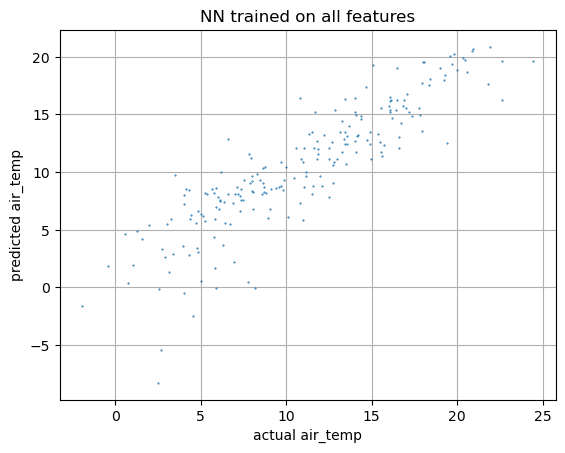

In [82]:
plt.plot(shifted_full.iloc[test_idx]['air_temp_nextday'],nn_surro_all.apply(nn_weight_all,test_data_all['x'])[:,0], '.', ms=1, label='NN')
plt.grid()
plt.xlabel('actual air_temp')
plt.ylabel('predicted air_temp')
plt.title('NN trained on all features')
print('median absolute deviation:', np.median(np.abs((nn_surro_all.apply(nn_weight_all,test_data_all['x'])[:,0] - shifted_full.iloc[test_idx]['air_temp_nextday']))))